## Bayesian Tomatoes

Casablanca | Jaws
---------- | ----
![casablanca](hw3_img/casablanca.jpg) |![jaws](hw3_img/jaws.jpg)

In this assignment, you'll be analyzing movie reviews from [Rotten Tomatoes](http://www.rottentomatoes.com). This assignment will cover:

 * Working with web APIs
 * Making and interpreting predictions from a Bayesian perspective
 * Using the Naive Bayes algorithm to predict whether a movie review is positive or negative
 * Using cross validation to optimize models

In [1]:
import pandas as pd
import numpy as np

"""   
helper python script that contains all functions 
referenced in this ipynb.
"""
%run hw3.py

### Introduction

`Rotten Tomatoes` gathers movie reviews from critics. An entry on the website typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked/disliked the movie.

When critics give quantitative ratings (say 3/4 stars, Thumbs up, etc.), determining the Fresh/Rotten classification is easy. However, publications like the New York Times don't assign numerical ratings to movies, and thus the Fresh/Rotten classification must be inferred from the text of the review itself.

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

    Is a movie review positive or negative?
    Is an email spam, or not?
    Is a comment on a blog discussion board appropriate, or not?
    Is a tweet about your company positive, or not?

Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques.

### The Data


In [2]:
from pandas.compat import StringIO

movies = pd.read_csv('../data/movies.dat', delimiter='\t')
movies.head()

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


In [2]:
critics = pd.read_csv('../data/critics.csv')
critics.head()

,critic,date,fresh,imdb,original_score,publication,quote,review_date,rt_id,title
0,Derek Adams,2009-10-04,fresh,114709,5/5,Time Out,"So ingenious in concept, design and execution ...",http://www.timeout.com/film/reviews/87745/toy-...,9559,Toy Story
1,Richard Corliss,2008-08-31,fresh,114709,NaN,TIME Magazine,The year's most inventive comedy.,"http://www.time.com/time/magazine/article/0,91...",9559,Toy Story
2,David Ansen,2008-08-18,fresh,114709,NaN,Newsweek,A winning animated feature that has something ...,http://www.newsweek.com/id/104199,9559,Toy Story
3,Leonard Klady,2008-06-09,fresh,114709,NaN,Variety,The film sports a provocative and appealing st...,http://www.variety.com/review/VE1117941294.htm...,9559,Toy Story
4,Jonathan Rosenbaum,2008-03-10,fresh,114709,NaN,Chicago Reader,"An entertaining computer-generated, hyperreali...",http://onfilm.chicagoreader.com/movies/capsule...,9559,Toy Story


### Exploration

In [17]:
# How many reviews, critics, and movies are in this dataset?
n_reviews = len(critics)
n_movies = critics.rt_id.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {}".format(n_reviews))
print("Number of critics: {}".format(n_critics))
print("Number of movies:  {}".format(n_movies))

Number of reviews: 15610
Number of critics: 622
Number of movies:  1931


#### What does the distribution of number of reviews per reviewer look like?

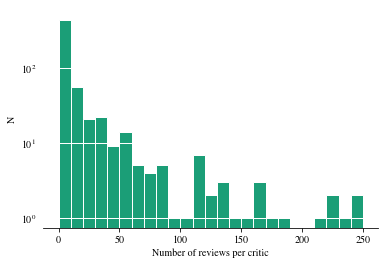

In [44]:
# after inspecting the data, remove top10 reviewers as outliers

critics.groupby('critic').rt_id.count().hist(log=True, bins=25, 
                                             ec='white', range=(0,250))

plt.xlabel("Number of reviews per critic")
plt.ylabel("N")
histogram_style()

#### List the 5 critics with the most reviews, along with the publication they write for

In [33]:
critics.groupby(['critic', 'publication']
               ).rt_id.count(
).sort_values(ascending=False).head(5)

critic              publication      
Roger Ebert         Chicago Sun-Times    1078
James Berardinelli  ReelViews             806
Janet Maslin        New York Times        519
Variety Staff       Variety               434
Jonathan Rosenbaum  Chicago Reader        414
Name: rt_id, dtype: int64

#### Of the critics with > 100 reviews, plot the distribution of average "freshness" rating per critic

In [7]:
df = critics.copy()
# turn fresh col into numerical
df['fresh'] = (df.fresh == 'fresh').astype(int)
df.head(1)

,critic,date,fresh,imdb,original_score,publication,quote,review_date,rt_id,title
0,Derek Adams,2009-10-04,1,114709,5/5,Time Out,"So ingenious in concept, design and execution ...",http://www.timeout.com/film/reviews/87745/toy-...,9559,Toy Story


In [17]:
fr100 = df.groupby(['critic']).aggregate({'rt_id':'count',
                                      'fresh':np.mean})
fr100 = fr100[fr100.rt_id > 100]
fr100.head()

,rt_id,fresh
critic,,
Bosley Crowther,139,0.705036
Dave Kehr,341,0.592375
Derek Adams,151,0.615894
Desson Thomson,391,0.588235
Edward Guthmann,119,0.647059


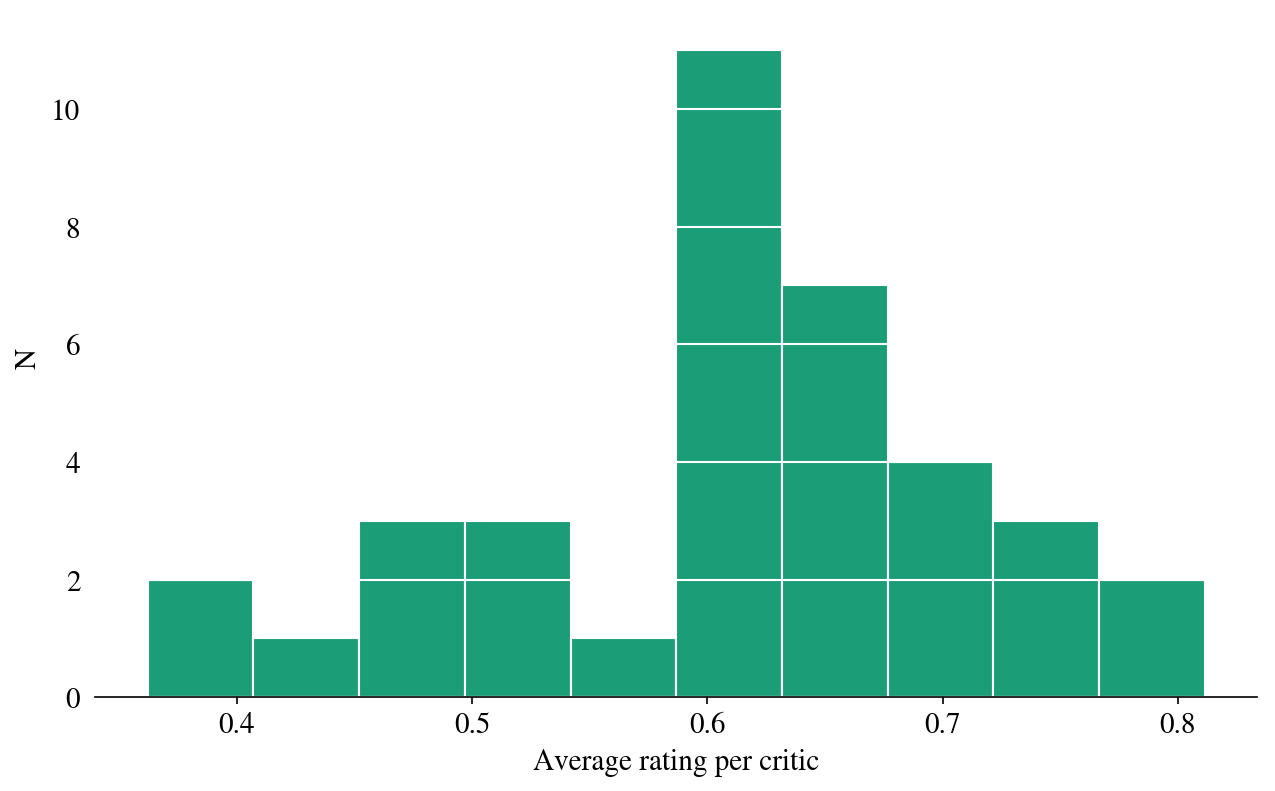

In [52]:
fr100.fresh.plot.hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10])
histogram_style()

####  Using the original `movies` dataframe, plot the rotten tomatoes Top Critics Rating as a function of year. Overplot the average for each year, ignoring the score=0 examples (some of these are missing data). 
#### `Is there a trend?`

In [44]:
data = movies[['year', 'rtTopCriticsRating']]
# convert Ratings to nums
data.rtTopCriticsRating = pd.to_numeric(data.rtTopCriticsRating , errors='coerce')
# ignore 0s
data = data[data.rtTopCriticsRating > 0]
# calculate the average ratings per year
means = data.groupby('year').mean().dropna()

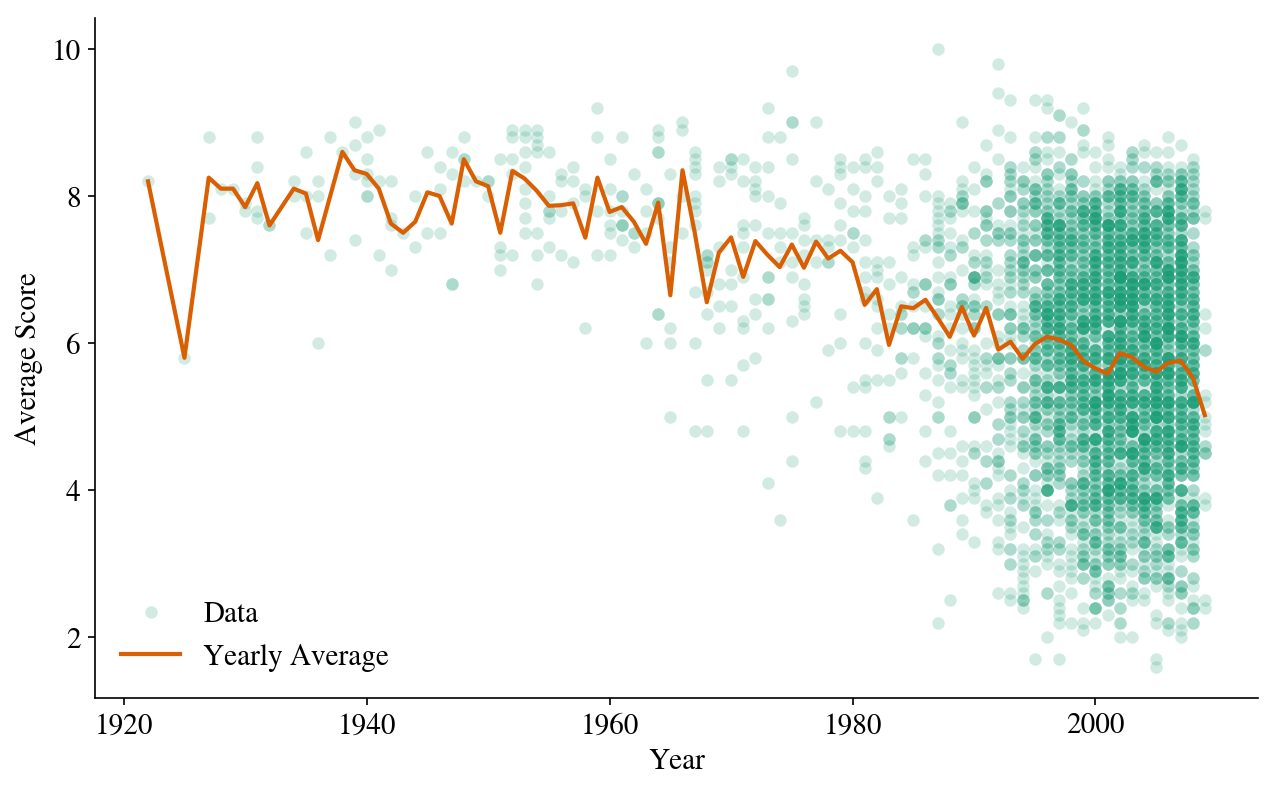

In [47]:
plt.plot(data['year'], data['rtTopCriticsRating'], 
         'o', mec='none', alpha=.2, label='Data')
plt.plot(means.index, means['rtTopCriticsRating'], 
         '-', label='Yearly Average')
plt.legend(loc='lower left', frameon=False)
plt.xlabel("Year")
plt.ylabel("Average Score")
remove_border()

***Analysis***

This graph shows a trend towards a lower average score, as well as a greater abundance of low scores, with time. This is probably at least partially `a selection effect` -- Rotten Tomatoes probably doesn't archive reviews for all movies, especially ones that came out before the website existed. 
Thus, reviews of old movies are more often "the classics". 
Mediocre old movies have been partially forgotten, and are underrepresented in the data.

---

## Sentiment Analysis

You will now use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review.

Most models work with numerical data, so we need to convert the textual collection of reviews to something numerical. 

A common strategy for text classification is to represent each review as a "`bag of words`" vector -- a long vector of numbers encoding how many times a particular word appears in a blurb.

Scikit-learn has an object called a `CountVectorizer` that turns text into a bag of words.

Using the `critics` dataframe, compute a pair of numerical X, Y arrays where:

- X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the input to your model.
- Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired output from your model.


In [99]:
X,Y = make_xy(critics)

In [100]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y)
clf = MultinomialNB().fit(xtrain, ytrain)

print("Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest)))

Accuracy: 78.61%


We say a model is overfit if it performs better on the training data than on the test data. 

Is this model overfit? If so, how much more accurate is the model on the training data compared to the test data?

In [101]:
print("Training Accuracy: %0.2f%%" % (100 * clf.score(xtrain, ytrain)))
print("Test Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest)))

Training Accuracy: 91.58%
Test Accuracy: 78.61%


There is indication of `overfitting`, since the `error rate on the test data (23%)` is more than twice as large as the `error rate on the training data (10%)`. Using  cross-validation, by repeatedly fitting and scoring the classifier on different train/test splits, we can discount it being a product od chance. 

***When the performance on the training data is consistently better than the test data, then overfitting has occured.***

---

### Model Calibration - Reliability Diagrams (Calibration Curves)

Bayesian models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification -- the `predict_proba` and `predict_log_proba` methods of MultinomialNB compute these probabilities.

Being the respectable Bayesian that you are, you should always assess whether these probabilities are `calibrated` -- that is, whether **a prediction made with a confidence of `x%` is correct approximately `x%` of the time**.

To model calibration you can utilise ***Reliability Diagrams (Calibration Curves)***.

A reliability diagram is a line plot of the relative frequency of what was observed (y-axis) versus the predicted probability frequency  (x-axis).

Specifically, `the predicted probabilities are divided up into a fixed number of buckets(bins) along the x-axis. The number of events (class=1) are then counted for each bin (e.g. the relative observed frequency). Finally, the counts are normalized`. The results are then plotted as a line plot.

***The better calibrated or more reliable a forecast, the closer the points will appear along the main diagonal from the bottom left to the top right of the plot.***

The position of the points or the curve relative to the diagonal can help to interpret the probabilities; for example:

- Below the diagonal: The model has `over-forecast`; the probabilities are too large.
- Above the diagonal: The model has `under-forecast`; the probabilities are too small.

***some empirical results suggest that the algorithms that can benefit the more from calibrating predicted probabilities include `SVMs, bagged decision trees, and random forests`.***

### Diagnose Calibration

You can diagnose the calibration of a classifier by creating a reliability diagram of the actual probabilities versus the predicted probabilities on a test set.

Text(0, 0.5, 'Empirical ~ P(Fresh)')

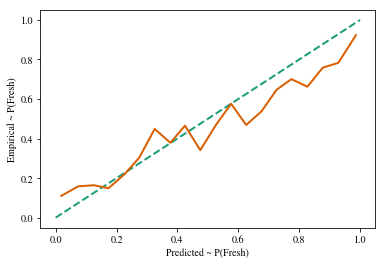

In [102]:
from sklearn.calibration import calibration_curve

# the model's estimated probabilities
probs = clf.predict_proba(xtest)[:,1]

# outputs the observed / estimated for each bin
p_true, p_pred = calibration_curve(ytest, probs, n_bins=20)

# plot the y=x as reference of perfect model fit
plt.plot(ytest, ytest, '--')

# plot the calibration curve
plt.plot(p_pred, p_true)

plt.xlabel("Predicted ~ P(Fresh)")
plt.ylabel("Empirical ~ P(Fresh)")

### Analysis

This model is ***over-confident***. For a properly calibrated model, we would expect ~10% of the P(Fresh)~0.1 reviews to actually be fresh. However, the actual freshness rate is closer to 30%. 

Likewise, for reviews where P(Fresh) ~0.9, the actuall freshness fraction is closer to 0.7. In other words, ***there is more uncertainty in the outcome than implied by the model.***


---

### Calibrate Classifier

A classifier can be calibrated in scikit-learn using the CalibratedClassifierCV class.

Via the `CalibratedClassifierCV`, we can fit multiple copies of the model using `Stratified k-fold` cross-validation and calibrate the probabilities predicted by these models using the hold out set. 

Predictions are made using each of the trained models.

In [103]:
from sklearn.calibration import CalibratedClassifierCV

clf = MultinomialNB()
calibrator = CalibratedClassifierCV(clf, cv=5, method='isotonic')
calibrator.fit(xtrain, ytrain)


CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
            cv=5, method='isotonic')

Text(0, 0.5, 'Empirical ~ P(Fresh)')

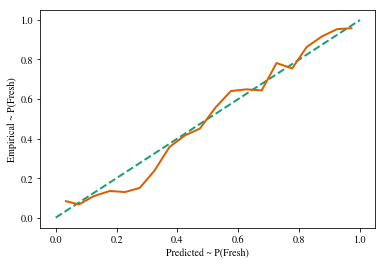

In [104]:
probs = calibrator.predict_proba(xtest)[:,1]

p_true, p_pred = calibration_curve(ytest, probs, n_bins=20)
plt.plot(ytest, ytest, '--')
plt.plot(p_pred, p_true)
plt.xlabel("Predicted ~ P(Fresh)")
plt.ylabel("Empirical ~ P(Fresh)")

In [105]:
training_accuracy = calibrator.score(xtrain, ytrain)
test_accuracy = calibrator.score(xtest, ytest)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Accuracy on training data: 0.92
Accuracy on test data:     0.79


---

### Cross Validation - HyperParameter Selection

Our classifier has a few free parameters. The two most important are:

- The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than min_df fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.

- The `alpha` keyword in the Bayesian classifier is a "`smoothing parameter`" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%.

In [107]:
X = critics.quote
Y = (critics.fresh == 'fresh').values.astype(int)

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = { 'vect__max_df': (0.75, 0.80, 1.0),
              'vect__min_df': (1e-5, 1e-4, 1e-3, 1e-2, 1e-1),
              #'vect__stop_words':('english', None),
              'clf__alpha': (0.5, 1, 2) 
              }
# find the best parameters for both the feature extraction and the classifier
grid_search = GridSearchCV(pipeline, parameters, cv=5,
                           n_jobs=-1, verbose=1)
grid_search.fit(X, Y)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.3min finished


Best score: 0.767
Best parameters set:
	clf__alpha: 2
	vect__max_df: 0.75
	vect__min_df: 0.0001


Having acquired the best values for our selected hyper-parameters, we retrain our model with these 

Text(0, 0.5, 'Empirical ~ P(Fresh)')

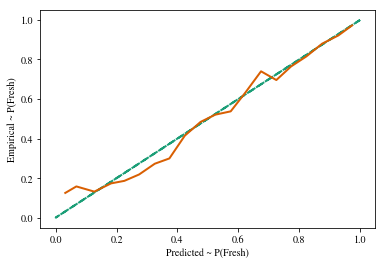

In [126]:
X,Y = make_xy(critics, vectorizer=CountVectorizer(max_df=0.75,
                                                 min_df=1e-3))

xtrain, xtest, ytrain, ytest = train_test_split(X, Y)

clf = MultinomialNB(alpha=2)

calibrator = CalibratedClassifierCV(clf, cv=5, method='isotonic')
calibrator.fit(xtrain, ytrain)


probs = calibrator.predict_proba(xtest)[:,1]

p_true, p_pred = calibration_curve(ytest, probs, n_bins=20)

plt.plot(ytest, ytest, '--')

plt.plot(p_pred, p_true)

plt.xlabel("Predicted ~ P(Fresh)")
plt.ylabel("Empirical ~ P(Fresh)")

In [127]:
training_accuracy = calibrator.score(xtrain, ytrain)
test_accuracy = calibrator.score(xtest, ytest)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Accuracy on training data: 0.79
Accuracy on test data:     0.75


### Analysis

The new model is slightly less accurate on the test data (74% vs 77% on the original model). However, it is both `better calibrated and less over-fit` than before. In other words, ***while the classification accuracy is slightly worse, the probabilities themselves are more accurate.***

---